# Creating The Model(s)

## Importing Libraries

In [1]:
# Data Handling
import json
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WhitespaceTokenizer
from stop_words import get_stop_words

#Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modelling
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes, svm

# Testing 
from sklearn.metrics import classification_report

# Exporting
from sklearn.pipeline import Pipeline
import joblib
import os

## Importing & Inspecting the Datasets

In [2]:
starnews_set = pd.read_csv('./kenyan-news/star-news.csv')
afpkenya_set = pd.read_csv('./kenyan-news/afp-kenya.csv')
pesacheck_set = pd.read_csv('./kenyan-news/pesa-check.csv')
realnews_set = pd.read_csv('./kenyan-news/real-news.csv')

In [3]:
starnews_set.head()

,Unnamed: 0,Title,Text,Status
0,0,Does wearing masks for a long period of time r...,Just like wearing a shoe when one leaves their...,PARTLY TRUE
1,1,"Four Std 8 pupils, two teachers have not succu...",Information circulating on social media that f...,FALSE
2,2,PARTLY TRUE: Safaricom calling for registratio...,A viral WhatsApp message claiming that Safaric...,FACT CHECKER
3,3,Raila's doctors haven't advised him to take a ...,A Facebook post claiming that ODM leader Raila...,FALSE
4,4,Photo claiming journalist shot dead during Bob...,A photo that has been circulating on social me...,FALSE


In [4]:
afpkenya_set.head()

,Unnamed: 0,Title,Text,Status
0,0,Fraudulent Facebook posts claim the World Bank...,Facebook posts inviting small business owners ...,1
1,1,Photos show Honduran migrants trying to enter ...,A post shared dozens of times on Facebook clai...,1
2,2,These pictures do not show torture scenes of o...,A Facebook post claiming to show images of tor...,1
3,3,This picture shows Italian performance artist ...,A bogus Facebook post claiming to show a white...,1
4,4,"This video shows a protest in South Africa, no...",A video viewed thousands of times has been sha...,1


In [5]:
pesacheck_set.head()

,Unnamed: 0,Title,Text,Label
0,0,This tweet of Kenyan businessman Buzeki critic...,A screenshot shared on Facebook claiming to sh...,FALSE:
1,1,Joyful Women Organization is not taking loan a...,A claim made on Facebook that the Joyful Women...,HOAX:
2,2,"This photo of Kenya’s former Prime Minister, R...",A photo shared on Facebook showing former Prim...,ALTERED:
3,3,This photo does not show men in Nigerian State...,This tweet with an image published on January ...,FALSE:
4,4,This advertisement for jobs at Café Javas Ugan...,A Facebook post claiming that Café Javas Ugand...,HOAX:


In [6]:
realnews_set.head()

,Unnamed: 0,Title,Text
0,0,"Betty Kyalo, Boniface Mwangi, Kipchoge feted i...","Sports personality Eliud Kipchoge, TV personal..."
1,1,Brown bottle: Why overcoming alcoholism is a s...,"It's brown, it's colourless, it comes in diffe..."
2,2,"Ugandan elections, Mighty Salim and Larry King...",Ugandan Elections and the deaths of renowned ‘...
3,3,Uhuru leads Kenyans in mourning former ministe...,President Uhuru Kenyatta has joined leaders in...
4,4,Unrest in schools likely fuelled by drug abuse...,The cases of unrest in schools might be a resu...


## Labelling

##### Pesa Check

In [7]:
pesacheck_set['Tag'] = np.nan

In [8]:
pesacheck_set.loc[pesacheck_set.Label == "TRUE", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "TRUE:", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "True:", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "FACT-CHECKED:", "Tag"] = 0
pesacheck_set.loc[pesacheck_set.Label == "Fact", "Tag"] = 0

In [9]:
(pesacheck_set['Tag']== 0).sum()

165

In [10]:
pesacheck_set.loc[pesacheck_set['Tag'].isnull(), "Tag"] = 1
pesacheck_set.loc[pesacheck_set['Text'].isnull(), "Text"] = " "

In [11]:
pesacheck_set.isnull().sum()

Unnamed: 0    0
Title         0
Text          0
Label         0
Tag           0
dtype: int64

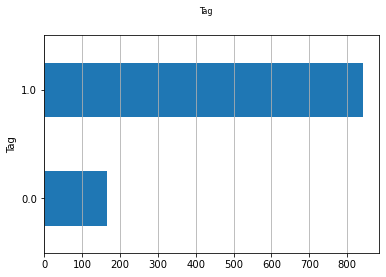

In [12]:
fig, ax = plt.subplots()
fig.suptitle("Tag", fontsize=8)
pesacheck_set["Tag"].reset_index().groupby("Tag").count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

In [13]:
pesacheck_set.head()

,Unnamed: 0,Title,Text,Label,Tag
0,0,This tweet of Kenyan businessman Buzeki critic...,A screenshot shared on Facebook claiming to sh...,FALSE:,1.0
1,1,Joyful Women Organization is not taking loan a...,A claim made on Facebook that the Joyful Women...,HOAX:,1.0
2,2,"This photo of Kenya’s former Prime Minister, R...",A photo shared on Facebook showing former Prim...,ALTERED:,1.0
3,3,This photo does not show men in Nigerian State...,This tweet with an image published on January ...,FALSE:,1.0
4,4,This advertisement for jobs at Café Javas Ugan...,A Facebook post claiming that Café Javas Ugand...,HOAX:,1.0


##### Star News 

In [14]:
starnews_set.isnull().sum()

Unnamed: 0     0
Title          0
Text           0
Status        20
dtype: int64

In [15]:
starnews_set.Status.unique()

array(['PARTLY TRUE', 'FALSE', 'FACT CHECKER', 'ALTERED', 'FACT CHECK',
       'HOAX', 'FAKE', nan, 'FAKE NEWS', 'UNPROVEN',
       'NO SCIENTIFIC EVIDENCE', 'MISLEADING', 'FACT-CHECK',
       'FAKE ACCOUNT', 'COVID-19 FACT CHECK', 'CORONAVIRUS', 'FALSE!',
       'CANCER-LINKS', 'KENYA EXIT', 'LIKONI FERRY TRAGEDY',
       'BACK IN ACTION', 'FALSE JOB ADVERTS', 'FALSE AD',
       'PERIOD SHAMING', 'ALL SYSTEMS GO', 'VACCINE',
       'APPOINTED COMMISSIONER', 'SUSPENSION', 'FALSE JOB ALERT',
       'TASTY EXPORT', 'KIBRA DECIDES'], dtype=object)

In [16]:
starnews_set['Tag'] = np.nan

In [17]:
starnews_set.loc[starnews_set['Status'].isnull(), "Status"] = " "

In [18]:
# UNPROVEN BACK IN ACTION ALL SYSTEMS GO
# APPOINTED COMMISSIONER KIBRA DECIDES TASTY EXPORT
starnews_set.loc[starnews_set.Status.str.startswith('ALL'), "Tag"] = 0
starnews_set.loc[starnews_set.Status.str.startswith('UNPROV'), "Tag"] = 0
starnews_set.loc[starnews_set.Status.str.startswith('BACK'), "Tag"] = 0
starnews_set.loc[starnews_set.Status.str.startswith('APPOI'), "Tag"] = 0
starnews_set.loc[starnews_set.Status.str.startswith('KIBR'), "Tag"] = 0
starnews_set.loc[starnews_set.Status.str.startswith('TAST'), "Tag"] = 0

In [19]:
(starnews_set['Tag']== 0).sum()

6

In [20]:
starnews_set.loc[starnews_set['Tag'].isnull(), "Tag"] = 1

###### AFP Kenya

In [21]:
afpkenya_set['Tag'] = np.nan
afpkenya_set.loc[afpkenya_set['Tag'].isnull(), "Tag"] = 1

##### Real News

In [22]:
realnews_set.isnull().sum()

Unnamed: 0    0
Title         0
Text          0
dtype: int64

In [23]:
realnews_set['Tag'] = np.nan
realnews_set.loc[realnews_set['Tag'].isnull(), "Tag"] = 0

### Combining the Data

In [24]:
pesacheck_set.rename(columns={'Label':'Status'}, inplace=True)

In [25]:
all_data = pd.concat([afpkenya_set, pesacheck_set, starnews_set, realnews_set])

In [26]:
all_data.shape[0]

2005

In [27]:
(all_data['Tag']== 0).sum()

1007

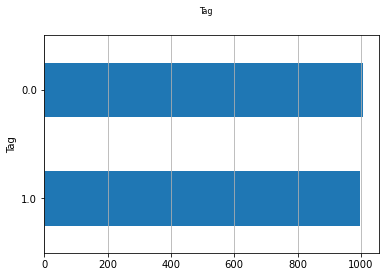

In [28]:
fig, ax = plt.subplots()
fig.suptitle("Tag", fontsize=8)
all_data["Tag"].reset_index().groupby("Tag").count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

In [29]:
all_data['Total'] = all_data['Title'] + all_data['Text']

## Preprocessing

##### Converting to Lower Case

In [30]:
all_data.loc[:,"Total"] = all_data.Total.apply(lambda x : str.lower(x))

In [31]:
all_data.Total

0      fraudulent facebook posts claim the world bank...
1      photos show honduran migrants trying to enter ...
2      these pictures do not show torture scenes of o...
3      this picture shows italian performance artist ...
4      this video shows a protest in south africa, no...
                             ...                        
831    senators want law to guide trial of impeached ...
832    state mulls flights restriction over new virus...
833    gideon: a big 'bullet' coalition in the offing...
834    agency that purged quacks keen to improve heal...
835    hospitals to be rated based on quality of care...
Name: Total, Length: 2005, dtype: object

##### Removing punctutations and numbers

In [32]:
all_data.loc[:,"Total"] = all_data.Total.apply(lambda x : " ".join(re.findall('[\w]+',x)))

In [33]:
all_data.Total

0      fraudulent facebook posts claim the world bank...
1      photos show honduran migrants trying to enter ...
2      these pictures do not show torture scenes of o...
3      this picture shows italian performance artist ...
4      this video shows a protest in south africa not...
                             ...                        
831    senators want law to guide trial of impeached ...
832    state mulls flights restriction over new virus...
833    gideon a big bullet coalition in the offingkan...
834    agency that purged quacks keen to improve heal...
835    hospitals to be rated based on quality of care...
Name: Total, Length: 2005, dtype: object

##### Removing website links

In [34]:
all_data.loc[:,"Total"] = all_data.Total.apply(lambda x : "".join(re.sub(r'http\S+', '', x)))

In [35]:
all_data.Total

0      fraudulent facebook posts claim the world bank...
1      photos show honduran migrants trying to enter ...
2      these pictures do not show torture scenes of o...
3      this picture shows italian performance artist ...
4      this video shows a protest in south africa not...
                             ...                        
831    senators want law to guide trial of impeached ...
832    state mulls flights restriction over new virus...
833    gideon a big bullet coalition in the offingkan...
834    agency that purged quacks keen to improve heal...
835    hospitals to be rated based on quality of care...
Name: Total, Length: 2005, dtype: object

##### Removing stopwords

In [36]:
stop_words = get_stop_words('en')

def remove_stopWords(s):
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

all_data.loc[:,"Total"] = all_data.Total.apply(lambda x: remove_stopWords(x))

In [37]:
all_data.Total

0      fraudulent facebook posts claim world bank giv...
1      photos show honduran migrants trying enter gua...
2      pictures show torture scenes opposition suppor...
3      picture shows italian performance artist vanes...
4      video shows protest south africa bobi wine sup...
                             ...                        
831    senators want law guide trial impeached govern...
832    state mulls flights restriction new virus stra...
833    gideon big bullet coalition offingkanu chairma...
834    agency purged quacks keen improve healthcareit...
835    hospitals rated based quality carethe governme...
Name: Total, Length: 2005, dtype: object

##### Lemmatizing the Text

In [38]:
lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    text = text.split()
    lemmatized_string = ' '.join([lemmatizer.lemmatize(word) for word in text])
    return lemmatized_string


all_data.loc[:,"Total"] = all_data.Total.apply(lemmatize_text)

In [39]:
all_data.Total

0      fraudulent facebook post claim world bank givi...
1      photo show honduran migrant trying enter guate...
2      picture show torture scene opposition supporte...
3      picture show italian performance artist vaness...
4      video show protest south africa bobi wine supp...
                             ...                        
831    senator want law guide trial impeached governo...
832    state mull flight restriction new virus strain...
833    gideon big bullet coalition offingkanu chairma...
834    agency purged quack keen improve healthcareit ...
835    hospital rated based quality carethe governmen...
Name: Total, Length: 2005, dtype: object

In [40]:
# Exporting the preprocessed data

path = '/home/jaden/Development/Notebooks/kenyan-news'
all_data.to_csv(os.path.join(path,r'all-news.csv'))

## Feature Extraction

In [41]:
x_train, x_test, y_train, y_test = train_test_split(all_data['Total'], all_data['Tag'], test_size=0.20, random_state=0)

In [42]:
tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1))
tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2))
tfidf_trigram = TfidfVectorizer(ngram_range=(3, 3))

In [43]:
#Unigram
tftrain_uni = tfidf_unigram.fit_transform(x_train)
tftest_uni = tfidf_unigram.transform(x_test)

#Bigram
tftrain_bi = tfidf_bigram.fit_transform(x_train)
tftest_bi = tfidf_bigram.transform(x_test)

#Trigram
tftrain_tri = tfidf_trigram.fit_transform(x_train)
tftest_tri = tfidf_trigram.transform(x_test)

In [53]:
count_unigram = CountVectorizer(ngram_range=(1, 1))
count_bigram = CountVectorizer(ngram_range=(2, 2))
count_trigram = CountVectorizer(ngram_range=(3, 3))

In [55]:
#Unigram
cntrain_uni = count_unigram.fit_transform(x_train)
cntest_uni = count_unigram.transform(x_test)

#Bigram
cntrain_bi = count_bigram.fit_transform(x_train)
cntest_bi = count_bigram.transform(x_test)

#Trigram
cntrain_tri = count_trigram.fit_transform(x_train)
cntest_tri = count_trigram.transform(x_test)

## Training & Testing the Model(s)

### Multinomial Naive Bayes

##### Training Multinomial Bayes

In [64]:
naive_tf = naive_bayes.MultinomialNB()
naive_tf.fit(tftrain_tri, y_train)

naive_cn = naive_bayes.MultinomialNB()
naive_cn.fit(cntrain_tri, y_train)

MultinomialNB()

##### Testing Multinomial Bayes

In [65]:
predict_naive_tf = naive_tf.predict(tftest_tri)
print(classification_report(y_test, predict_naive_tf))

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.85       200
         1.0       0.80      0.99      0.88       201

    accuracy                           0.87       401
   macro avg       0.89      0.87      0.86       401
weighted avg       0.89      0.87      0.86       401



In [66]:
predict_naive_cn = naive_cn.predict(cntest_tri)
print(classification_report(y_test, predict_naive_cn))

              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87       200
         1.0       0.82      0.99      0.90       201

    accuracy                           0.89       401
   macro avg       0.90      0.89      0.88       401
weighted avg       0.90      0.89      0.88       401



### Logistic Regression

##### Training Logistic Regression

In [84]:
logreg_tf = LogisticRegression(C = 1e5, max_iter = 500)
logreg_tf.fit(tftrain_tri, y_train)

LogisticRegression(C=100000.0, max_iter=500)

In [87]:
logreg_cn = LogisticRegression(C = 1e5, max_iter = 2000)
logreg_cn.fit(cntrain_tri, y_train)

LogisticRegression(C=100000.0, max_iter=2000)

##### Testing Logistic Regression

In [88]:
predict_logreg_tf = logreg_tf.predict(tftest_tri)
print(classification_report(y_test, predict_logreg_tf))

              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75       200
         1.0       0.75      0.77      0.76       201

    accuracy                           0.75       401
   macro avg       0.75      0.75      0.75       401
weighted avg       0.75      0.75      0.75       401



In [90]:
predict_logreg_cn = logreg_cn.predict(cntest_tri)
print(classification_report(y_test, predict_logreg_cn))

              precision    recall  f1-score   support

         0.0       0.67      0.41      0.51       200
         1.0       0.58      0.80      0.67       201

    accuracy                           0.61       401
   macro avg       0.62      0.61      0.59       401
weighted avg       0.62      0.61      0.59       401



### Passive Agressive

##### Training Passive Agressive

In [46]:
passagg_tf = PassiveAggressiveClassifier()
passagg_tf.fit(tftrain_bi, y_train)

PassiveAggressiveClassifier()

In [101]:
passagg_cn = PassiveAggressiveClassifier()
passagg_cn.fit(cntrain_tri, y_train)

PassiveAggressiveClassifier()

##### Testing Passive Agressive

In [47]:
predict_passagg_tf = passagg_tf.predict(tftest_bi)
print(classification_report(y_test, predict_passagg_tf))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       200
         1.0       0.90      0.96      0.93       201

    accuracy                           0.92       401
   macro avg       0.92      0.92      0.92       401
weighted avg       0.92      0.92      0.92       401



In [102]:
predict_passagg_cn = passagg_cn.predict(tftest_tri)
print(classification_report(y_test, predict_passagg_cn))

              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       200
         1.0       0.88      0.94      0.91       201

    accuracy                           0.91       401
   macro avg       0.91      0.91      0.91       401
weighted avg       0.91      0.91      0.91       401



### SVM Model

##### Training SVM model

In [111]:
svm_tf = svm.SVC(kernel = "linear")
svm_tf.fit(tftrain_tri, y_train)

SVC(kernel='linear')

In [112]:
svm_cn = svm.SVC(kernel = "linear")
svm_cn.fit(cntrain_tri, y_train)

SVC(kernel='linear')

##### Testing SVM model

In [113]:
predict_svm_tf = svm_tf.predict(tftest_tri)
print(classification_report(y_test, predict_svm_tf))

              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89       200
         1.0       0.86      0.95      0.90       201

    accuracy                           0.90       401
   macro avg       0.90      0.90      0.90       401
weighted avg       0.90      0.90      0.90       401



In [114]:
predict_svm_cn = svm_cn.predict(cntest_tri)
print(classification_report(y_test, predict_svm_cn))

              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78       200
         1.0       0.75      0.91      0.82       201

    accuracy                           0.81       401
   macro avg       0.82      0.81      0.80       401
weighted avg       0.82      0.81      0.80       401



## Pipeline

In [48]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 1))),
    ('passagg', PassiveAggressiveClassifier()),
])

In [49]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('passagg', PassiveAggressiveClassifier())])

In [50]:
filename = 'tf_passagg.sav'
joblib.dump(pipeline, filename)

['tf_passagg.sav']